# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

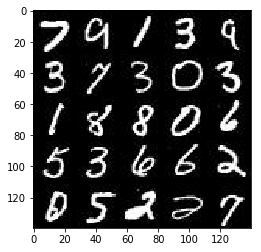

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

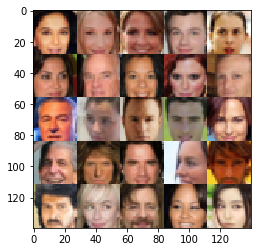

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        alpha=0.1
        
        # print(images.shape)
        
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        # print(x.shape)
        relu = tf.maximum(alpha * x, x)
                
        x = tf.layers.conv2d(relu, 128, 4, strides=2, padding='SAME')
        # print(x.shape)
        bn = tf.layers.batch_normalization(x, training=True)
        relu = tf.maximum(alpha * bn, bn)
                
        x = tf.layers.conv2d(relu, 256, 5, strides=2, padding='SAME')
        # print(x.shape)
        bn = tf.layers.batch_normalization(x, training=True)
        relu = tf.maximum(alpha * bn, bn)
        
        relu = tf.nn.dropout(relu, keep_prob=0.75)
        
        # Flatten it
        flat = tf.reshape(relu, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*256)
        
        x = tf.reshape(x, (-1, 4, 4, 256))
        # print(x.shape)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=1, padding='valid')
        # print(x.shape)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        # print(x.shape)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.nn.dropout(x, keep_prob=0.75)
        
        # Output layer
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        # print(x.shape)
        x = tf.reshape(x, (-1, 28, 28, out_channel_dim))
        
        return tf.tanh(x)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    count_batch = 0
    show_every = 100
    print_every = 10
    n_images = 20
        
    # tf.reset_default_graph()
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_training, g_training = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                count_batch += 1 
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_training, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_training, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if count_batch % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}|Batch {}...".format(epoch_i+1, epoch_count, count_batch),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if count_batch % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode) 


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2|Batch 10... Discriminator Loss: 0.5994... Generator Loss: 1.3533
Epoch 1/2|Batch 20... Discriminator Loss: 1.2478... Generator Loss: 0.5194
Epoch 1/2|Batch 30... Discriminator Loss: 0.7053... Generator Loss: 0.9483
Epoch 1/2|Batch 40... Discriminator Loss: 0.6043... Generator Loss: 2.9497
Epoch 1/2|Batch 50... Discriminator Loss: 0.3240... Generator Loss: 2.5097
Epoch 1/2|Batch 60... Discriminator Loss: 0.3261... Generator Loss: 1.9112
Epoch 1/2|Batch 70... Discriminator Loss: 0.2795... Generator Loss: 2.1023
Epoch 1/2|Batch 80... Discriminator Loss: 0.6617... Generator Loss: 0.9794
Epoch 1/2|Batch 90... Discriminator Loss: 0.2200... Generator Loss: 2.6578
Epoch 1/2|Batch 100... Discriminator Loss: 0.1718... Generator Loss: 2.6589


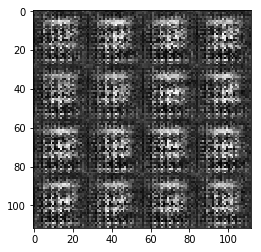

Epoch 1/2|Batch 110... Discriminator Loss: 0.1092... Generator Loss: 3.2643
Epoch 1/2|Batch 120... Discriminator Loss: 0.0646... Generator Loss: 3.8756
Epoch 1/2|Batch 130... Discriminator Loss: 0.0880... Generator Loss: 3.3796
Epoch 1/2|Batch 140... Discriminator Loss: 7.1200... Generator Loss: 15.0864
Epoch 1/2|Batch 150... Discriminator Loss: 0.2848... Generator Loss: 2.4095
Epoch 1/2|Batch 160... Discriminator Loss: 0.1640... Generator Loss: 2.9917
Epoch 1/2|Batch 170... Discriminator Loss: 0.1292... Generator Loss: 3.1149
Epoch 1/2|Batch 180... Discriminator Loss: 0.8001... Generator Loss: 0.9623
Epoch 1/2|Batch 190... Discriminator Loss: 0.4415... Generator Loss: 1.6664
Epoch 1/2|Batch 200... Discriminator Loss: 0.3067... Generator Loss: 2.2901


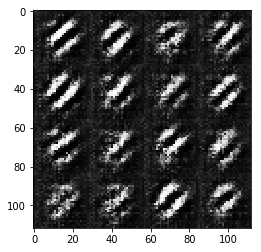

Epoch 1/2|Batch 210... Discriminator Loss: 0.2535... Generator Loss: 2.3694
Epoch 1/2|Batch 220... Discriminator Loss: 0.3404... Generator Loss: 4.8450
Epoch 1/2|Batch 230... Discriminator Loss: 0.1128... Generator Loss: 3.2396
Epoch 1/2|Batch 240... Discriminator Loss: 0.1204... Generator Loss: 3.4985
Epoch 1/2|Batch 250... Discriminator Loss: 0.1338... Generator Loss: 4.4472
Epoch 1/2|Batch 260... Discriminator Loss: 0.1031... Generator Loss: 3.1225
Epoch 1/2|Batch 270... Discriminator Loss: 0.0588... Generator Loss: 3.9578
Epoch 1/2|Batch 280... Discriminator Loss: 0.0777... Generator Loss: 3.4435
Epoch 1/2|Batch 290... Discriminator Loss: 0.0555... Generator Loss: 4.3324
Epoch 1/2|Batch 300... Discriminator Loss: 0.0500... Generator Loss: 4.3084


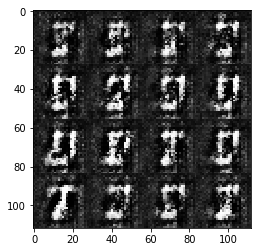

Epoch 1/2|Batch 310... Discriminator Loss: 0.0661... Generator Loss: 3.8877
Epoch 1/2|Batch 320... Discriminator Loss: 0.0512... Generator Loss: 3.9599
Epoch 1/2|Batch 330... Discriminator Loss: 14.9903... Generator Loss: 17.2543
Epoch 1/2|Batch 340... Discriminator Loss: 0.1739... Generator Loss: 2.4412
Epoch 1/2|Batch 350... Discriminator Loss: 0.2643... Generator Loss: 2.2160
Epoch 1/2|Batch 360... Discriminator Loss: 0.1299... Generator Loss: 2.9892
Epoch 1/2|Batch 370... Discriminator Loss: 0.0883... Generator Loss: 3.4830
Epoch 1/2|Batch 380... Discriminator Loss: 0.1109... Generator Loss: 3.4519
Epoch 1/2|Batch 390... Discriminator Loss: 0.1073... Generator Loss: 3.2078
Epoch 1/2|Batch 400... Discriminator Loss: 0.1277... Generator Loss: 2.8985


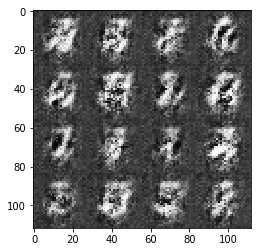

Epoch 1/2|Batch 410... Discriminator Loss: 2.2119... Generator Loss: 0.2080
Epoch 1/2|Batch 420... Discriminator Loss: 0.2192... Generator Loss: 2.5445
Epoch 1/2|Batch 430... Discriminator Loss: 0.2904... Generator Loss: 2.3205
Epoch 1/2|Batch 440... Discriminator Loss: 0.2183... Generator Loss: 2.4913
Epoch 1/2|Batch 450... Discriminator Loss: 0.1833... Generator Loss: 2.7536
Epoch 1/2|Batch 460... Discriminator Loss: 0.1481... Generator Loss: 3.2709
Epoch 2/2|Batch 470... Discriminator Loss: 0.1690... Generator Loss: 2.6460
Epoch 2/2|Batch 480... Discriminator Loss: 0.3131... Generator Loss: 2.5666
Epoch 2/2|Batch 490... Discriminator Loss: 0.2406... Generator Loss: 2.3414
Epoch 2/2|Batch 500... Discriminator Loss: 0.2577... Generator Loss: 2.3188


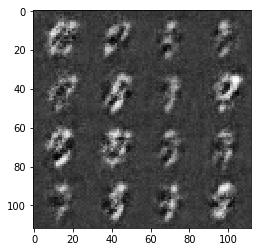

Epoch 2/2|Batch 510... Discriminator Loss: 0.1939... Generator Loss: 2.8201
Epoch 2/2|Batch 520... Discriminator Loss: 0.1964... Generator Loss: 2.6182
Epoch 2/2|Batch 530... Discriminator Loss: 0.1540... Generator Loss: 2.9441
Epoch 2/2|Batch 540... Discriminator Loss: 0.1315... Generator Loss: 3.0772
Epoch 2/2|Batch 550... Discriminator Loss: 0.1245... Generator Loss: 3.2423
Epoch 2/2|Batch 560... Discriminator Loss: 0.1578... Generator Loss: 2.8663
Epoch 2/2|Batch 570... Discriminator Loss: 0.1062... Generator Loss: 3.5962
Epoch 2/2|Batch 580... Discriminator Loss: 0.1177... Generator Loss: 3.3043
Epoch 2/2|Batch 590... Discriminator Loss: 0.3360... Generator Loss: 1.6003
Epoch 2/2|Batch 600... Discriminator Loss: 0.2501... Generator Loss: 2.5074


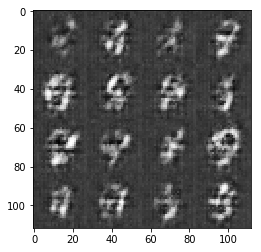

Epoch 2/2|Batch 610... Discriminator Loss: 0.1893... Generator Loss: 2.6190
Epoch 2/2|Batch 620... Discriminator Loss: 0.1839... Generator Loss: 2.7753
Epoch 2/2|Batch 630... Discriminator Loss: 0.1142... Generator Loss: 3.2257
Epoch 2/2|Batch 640... Discriminator Loss: 0.1565... Generator Loss: 2.7897
Epoch 2/2|Batch 650... Discriminator Loss: 0.0862... Generator Loss: 3.3447
Epoch 2/2|Batch 660... Discriminator Loss: 0.0963... Generator Loss: 3.5070
Epoch 2/2|Batch 670... Discriminator Loss: 0.1139... Generator Loss: 3.2677
Epoch 2/2|Batch 680... Discriminator Loss: 0.0831... Generator Loss: 3.1840
Epoch 2/2|Batch 690... Discriminator Loss: 0.0825... Generator Loss: 3.3983
Epoch 2/2|Batch 700... Discriminator Loss: 0.0983... Generator Loss: 3.4845


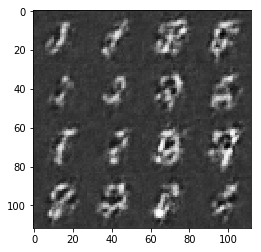

Epoch 2/2|Batch 710... Discriminator Loss: 0.1029... Generator Loss: 3.2642
Epoch 2/2|Batch 720... Discriminator Loss: 0.0835... Generator Loss: 4.0464
Epoch 2/2|Batch 730... Discriminator Loss: 0.0778... Generator Loss: 3.4731
Epoch 2/2|Batch 740... Discriminator Loss: 0.0456... Generator Loss: 4.2365
Epoch 2/2|Batch 750... Discriminator Loss: 0.0386... Generator Loss: 4.1204
Epoch 2/2|Batch 760... Discriminator Loss: 0.0429... Generator Loss: 4.1456
Epoch 2/2|Batch 770... Discriminator Loss: 0.0693... Generator Loss: 3.5225
Epoch 2/2|Batch 780... Discriminator Loss: 0.0455... Generator Loss: 3.8063
Epoch 2/2|Batch 790... Discriminator Loss: 0.0799... Generator Loss: 3.6478
Epoch 2/2|Batch 800... Discriminator Loss: 0.0534... Generator Loss: 4.0444


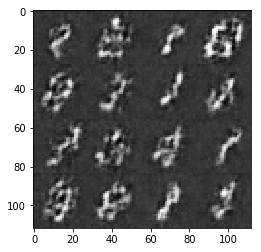

Epoch 2/2|Batch 810... Discriminator Loss: 0.0857... Generator Loss: 3.3679
Epoch 2/2|Batch 820... Discriminator Loss: 0.0507... Generator Loss: 4.0896
Epoch 2/2|Batch 830... Discriminator Loss: 0.0543... Generator Loss: 4.3387
Epoch 2/2|Batch 840... Discriminator Loss: 0.0466... Generator Loss: 4.2530
Epoch 2/2|Batch 850... Discriminator Loss: 0.0375... Generator Loss: 4.0915
Epoch 2/2|Batch 860... Discriminator Loss: 0.0370... Generator Loss: 4.5419
Epoch 2/2|Batch 870... Discriminator Loss: 0.0538... Generator Loss: 4.0011
Epoch 2/2|Batch 880... Discriminator Loss: 0.0348... Generator Loss: 4.5846
Epoch 2/2|Batch 890... Discriminator Loss: 0.0484... Generator Loss: 3.9554
Epoch 2/2|Batch 900... Discriminator Loss: 0.0345... Generator Loss: 4.9126


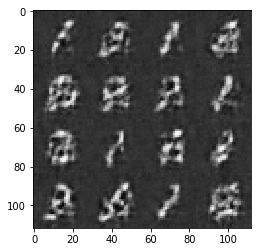

Epoch 2/2|Batch 910... Discriminator Loss: 0.0337... Generator Loss: 4.6630
Epoch 2/2|Batch 920... Discriminator Loss: 0.0536... Generator Loss: 4.2868
Epoch 2/2|Batch 930... Discriminator Loss: 0.0488... Generator Loss: 3.9261


In [12]:
batch_size = 128
z_dim = 500
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1|Batch 10... Discriminator Loss: 0.4164... Generator Loss: 2.1009
Epoch 1/1|Batch 20... Discriminator Loss: 0.3481... Generator Loss: 4.1850
Epoch 1/1|Batch 30... Discriminator Loss: 0.2856... Generator Loss: 3.5421
Epoch 1/1|Batch 40... Discriminator Loss: 0.1985... Generator Loss: 2.8317
Epoch 1/1|Batch 50... Discriminator Loss: 0.2091... Generator Loss: 2.3700
Epoch 1/1|Batch 60... Discriminator Loss: 0.2521... Generator Loss: 2.6439
Epoch 1/1|Batch 70... Discriminator Loss: 0.1699... Generator Loss: 2.5593
Epoch 1/1|Batch 80... Discriminator Loss: 0.1465... Generator Loss: 3.2038
Epoch 1/1|Batch 90... Discriminator Loss: 0.1430... Generator Loss: 2.8012
Epoch 1/1|Batch 100... Discriminator Loss: 0.0977... Generator Loss: 3.5566


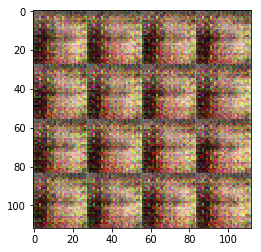

Epoch 1/1|Batch 110... Discriminator Loss: 0.1447... Generator Loss: 6.8926
Epoch 1/1|Batch 120... Discriminator Loss: 0.1384... Generator Loss: 2.8263
Epoch 1/1|Batch 130... Discriminator Loss: 0.0772... Generator Loss: 3.7249
Epoch 1/1|Batch 140... Discriminator Loss: 0.0877... Generator Loss: 3.3785
Epoch 1/1|Batch 150... Discriminator Loss: 0.0534... Generator Loss: 4.2175
Epoch 1/1|Batch 160... Discriminator Loss: 0.0596... Generator Loss: 3.7813
Epoch 1/1|Batch 170... Discriminator Loss: 0.0534... Generator Loss: 3.8519
Epoch 1/1|Batch 180... Discriminator Loss: 0.0374... Generator Loss: 4.2180
Epoch 1/1|Batch 190... Discriminator Loss: 0.0253... Generator Loss: 4.8150
Epoch 1/1|Batch 200... Discriminator Loss: 0.0249... Generator Loss: 4.7477


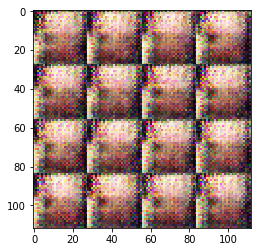

Epoch 1/1|Batch 210... Discriminator Loss: 0.0207... Generator Loss: 4.7912
Epoch 1/1|Batch 220... Discriminator Loss: 0.0224... Generator Loss: 4.6423
Epoch 1/1|Batch 230... Discriminator Loss: 0.0234... Generator Loss: 4.7373
Epoch 1/1|Batch 240... Discriminator Loss: 0.0172... Generator Loss: 4.9310
Epoch 1/1|Batch 250... Discriminator Loss: 0.0170... Generator Loss: 5.0193
Epoch 1/1|Batch 260... Discriminator Loss: 0.0121... Generator Loss: 5.1423
Epoch 1/1|Batch 270... Discriminator Loss: 0.0119... Generator Loss: 5.1598
Epoch 1/1|Batch 280... Discriminator Loss: 0.0138... Generator Loss: 4.9192
Epoch 1/1|Batch 290... Discriminator Loss: 0.0145... Generator Loss: 4.9986
Epoch 1/1|Batch 300... Discriminator Loss: 0.0118... Generator Loss: 5.5253


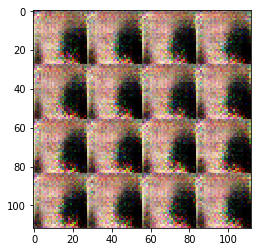

Epoch 1/1|Batch 310... Discriminator Loss: 0.0120... Generator Loss: 5.3969
Epoch 1/1|Batch 320... Discriminator Loss: 0.0191... Generator Loss: 4.9295
Epoch 1/1|Batch 330... Discriminator Loss: 0.4937... Generator Loss: 1.7145
Epoch 1/1|Batch 340... Discriminator Loss: 0.2226... Generator Loss: 2.2524
Epoch 1/1|Batch 350... Discriminator Loss: 0.0609... Generator Loss: 3.9577
Epoch 1/1|Batch 360... Discriminator Loss: 0.0562... Generator Loss: 3.9242
Epoch 1/1|Batch 370... Discriminator Loss: 0.0623... Generator Loss: 3.5886
Epoch 1/1|Batch 380... Discriminator Loss: 0.0359... Generator Loss: 4.1034
Epoch 1/1|Batch 390... Discriminator Loss: 0.0433... Generator Loss: 3.9971
Epoch 1/1|Batch 400... Discriminator Loss: 0.0614... Generator Loss: 3.6117


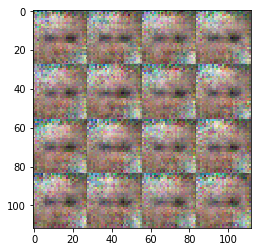

Epoch 1/1|Batch 410... Discriminator Loss: 1.3203... Generator Loss: 3.4985
Epoch 1/1|Batch 420... Discriminator Loss: 0.3899... Generator Loss: 3.1495
Epoch 1/1|Batch 430... Discriminator Loss: 0.2581... Generator Loss: 2.2796
Epoch 1/1|Batch 440... Discriminator Loss: 0.2462... Generator Loss: 2.2850
Epoch 1/1|Batch 450... Discriminator Loss: 0.1069... Generator Loss: 3.2112
Epoch 1/1|Batch 460... Discriminator Loss: 0.0937... Generator Loss: 3.6199
Epoch 1/1|Batch 470... Discriminator Loss: 0.0865... Generator Loss: 4.0082
Epoch 1/1|Batch 480... Discriminator Loss: 0.2456... Generator Loss: 4.2438
Epoch 1/1|Batch 490... Discriminator Loss: 0.1165... Generator Loss: 3.5383
Epoch 1/1|Batch 500... Discriminator Loss: 0.4553... Generator Loss: 5.9897


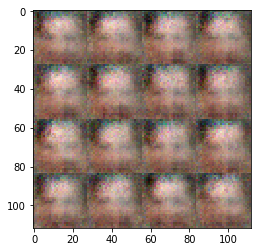

Epoch 1/1|Batch 510... Discriminator Loss: 0.1943... Generator Loss: 3.3026
Epoch 1/1|Batch 520... Discriminator Loss: 0.2537... Generator Loss: 2.9665
Epoch 1/1|Batch 530... Discriminator Loss: 0.6792... Generator Loss: 3.3818
Epoch 1/1|Batch 540... Discriminator Loss: 0.4273... Generator Loss: 2.0118
Epoch 1/1|Batch 550... Discriminator Loss: 0.4375... Generator Loss: 4.8213
Epoch 1/1|Batch 560... Discriminator Loss: 0.2072... Generator Loss: 2.8569
Epoch 1/1|Batch 570... Discriminator Loss: 0.1893... Generator Loss: 2.5839
Epoch 1/1|Batch 580... Discriminator Loss: 0.2977... Generator Loss: 1.9323
Epoch 1/1|Batch 590... Discriminator Loss: 0.5081... Generator Loss: 8.2647
Epoch 1/1|Batch 600... Discriminator Loss: 0.5797... Generator Loss: 4.8967


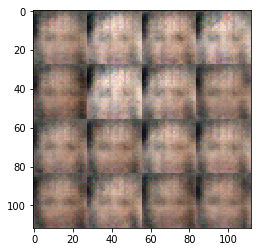

Epoch 1/1|Batch 610... Discriminator Loss: 0.3815... Generator Loss: 2.0043
Epoch 1/1|Batch 620... Discriminator Loss: 0.4473... Generator Loss: 2.1134
Epoch 1/1|Batch 630... Discriminator Loss: 0.5032... Generator Loss: 1.7167
Epoch 1/1|Batch 640... Discriminator Loss: 0.4287... Generator Loss: 1.8581
Epoch 1/1|Batch 650... Discriminator Loss: 0.8929... Generator Loss: 0.8590
Epoch 1/1|Batch 660... Discriminator Loss: 0.4360... Generator Loss: 1.7456
Epoch 1/1|Batch 670... Discriminator Loss: 0.8339... Generator Loss: 0.8585
Epoch 1/1|Batch 680... Discriminator Loss: 0.3702... Generator Loss: 2.7430
Epoch 1/1|Batch 690... Discriminator Loss: 2.0013... Generator Loss: 8.3931
Epoch 1/1|Batch 700... Discriminator Loss: 0.3423... Generator Loss: 2.2777


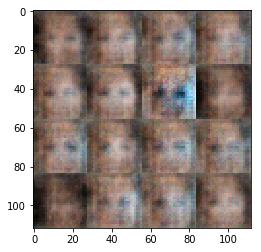

Epoch 1/1|Batch 710... Discriminator Loss: 0.3594... Generator Loss: 1.6661
Epoch 1/1|Batch 720... Discriminator Loss: 0.2879... Generator Loss: 2.2415
Epoch 1/1|Batch 730... Discriminator Loss: 0.3177... Generator Loss: 2.5745
Epoch 1/1|Batch 740... Discriminator Loss: 0.5150... Generator Loss: 1.3495
Epoch 1/1|Batch 750... Discriminator Loss: 0.2859... Generator Loss: 4.1019
Epoch 1/1|Batch 760... Discriminator Loss: 0.5208... Generator Loss: 1.7632
Epoch 1/1|Batch 770... Discriminator Loss: 0.4310... Generator Loss: 1.5991
Epoch 1/1|Batch 780... Discriminator Loss: 0.4127... Generator Loss: 1.9926
Epoch 1/1|Batch 790... Discriminator Loss: 0.5473... Generator Loss: 1.5320


In [ ]:
batch_size = 128
z_dim = 500
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.